By: Yen Lee Loh (2023-05-16)

# TensorFlow Tutorial: 3. Binary classification of images [INCOMPLETE]

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3,suppress=True)
rng = np.random.default_rng()
import tensorflow.keras as keras
from tqdm.keras import TqdmCallback
import cute ; import importlib ; importlib.reload (cute) ;

2023-06-08 14:30:09.631365: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$
$\newcommand{\mat}[1]{\underline{\underline{\mathbf{#1}}}}$
$\newcommand{\beq}{\qquad\begin{align}}$
$\newcommand{\eeq}{\end{align}}$
$\newcommand{\half}{\frac{1}{2}}$



$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$
$\newcommand{\mat}[1]{\underline{\underline{\mathbf{#1}}}}$
$\newcommand{\beq}{\qquad\begin{align}}$
$\newcommand{\eeq}{\end{align}}$
$\newcommand{\half}{\frac{1}{2}}$


## Binary classification of synthetic images

### Generate synthetic images and split into training and validation datasets

In [6]:
def select (inputs, outputs, classes, nT, nV, shuffle=False):
  assert len(classes) == len(nT) and len(nT) == len(nV)
  allT = []
  allV = []
  for k in range(len(classes)):
    indices, = np.where(outputs==classes[k])
    ntot = len(indices)
    indices = rng.choice (indices, nT[k] + nV[k], False)    # randomly choose 300
    indicesT,indicesV = np.split (indices, [nT[k]])
    allT += indicesT.tolist()
    allV += indicesV.tolist()
    print ('For class {}, given {} examples, we chose {} for training and {} for validation. '.format(classes[k], ntot, len(indicesT), len(indicesV)))
  if shuffle:
    rng.shuffle (allT)
    rng.shuffle (allV)
  return inputs[allT], outputs[allT], inputs[allV], outputs[allV]
import collections.abc as abc
def gallery(xnij, cmap='viridis', labels=None, size=1):  # size is in inches
  '''Display a row of images
  '''  
  nmax = len(xnij)
  cols = min(20,nmax) ; rows = (nmax+cols-1)//cols
  wspace = 0.02 ; hspace = 0.02
  if isinstance (labels, abc.Iterable) or labels!=None:   # if user has supplied labels
    hspace = .35    
  fig,axs = plt.subplots (rows,cols, figsize=(cols*size*(1+wspace),rows*size*(1+hspace)), gridspec_kw={'wspace':wspace,'hspace':hspace})
  if nmax==1: axs = np.array([[axs]])
  axs = axs.flatten()
  for ax in axs: ax.axis ('off')
  for n in range(nmax):
      ax = axs[n]
      if isinstance (cmap, abc.Iterable) and not isinstance (cmap, str): c = cmap[n]
      else: c = cmap
      ax.imshow (xnij[n], cmap=c)
      ax.set_aspect('equal')
      if isinstance (labels, abc.Iterable):
        ax.set_title (str(labels[n]))

For class 0, given 60 examples, we chose 30 for training and 30 for validation. 
For class 1, given 60 examples, we chose 30 for training and 30 for validation. 


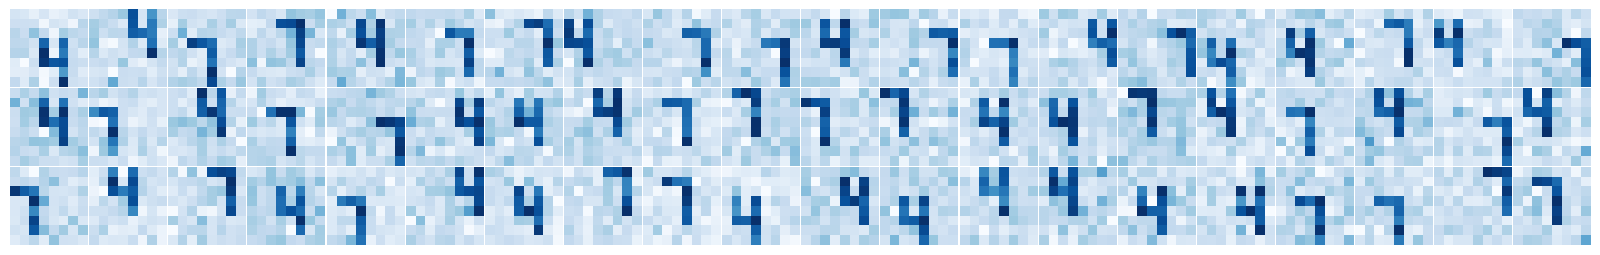

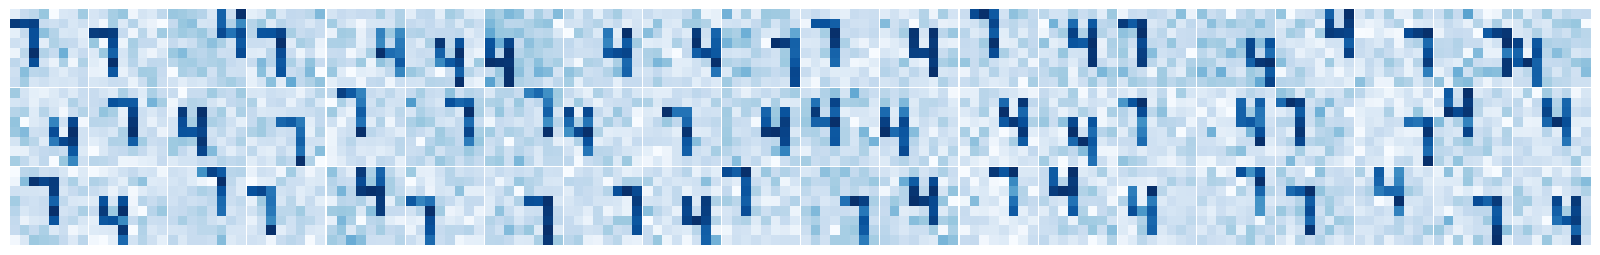

In [15]:
#================ SET USER-DEFINED PARAMETERS
imax,jmax = 8,8        # image sizes
nmaxT,nmaxV = 60,60   # number of training and validation examples. Could be (20,100)
nmax = nmaxT + nmaxV   # total
noiselevel = 0.15
#noiselevel = 0.01
pattern0 = np.array ([
  [1,1,1],
  [0,0,1],
  [0,0,1],
  [0,0,1],
  [0,0,1],
])
pattern1 = np.array ([
  [1,0,1],
  [1,0,1],
  [1,1,1],
  [0,0,1],
  [0,0,1],
])
Imax = imax+1-pattern1.shape[0]
Jmax = jmax+1-pattern1.shape[1]
#shiftwindow = [[Imax//2,Jmax//2],[Imax//2+1,Jmax//2+1]]  # fixed shift
shiftwindow = [[0,0], [imax+1-pattern1.shape[0],jmax+1-pattern1.shape[1]]]  # variable shift
#================ FABRICATE THE DATASET
xnij = []
yn = []
for iter in range(nmax//2):
  xij = noiselevel*rng.standard_normal ([imax,jmax])                 # noise
  i0,j0 = rng.integers (*shiftwindow)                                # shift
  xij[i0:i0+pattern0.shape[0], j0:j0+pattern0.shape[1]] += pattern0  # stamp
  xnij += [xij]
  yn += [0]
for iter in range(nmax//2):
  xij = noiselevel*rng.standard_normal ([imax,jmax])                 # noise
  i0,j0 = rng.integers (*shiftwindow)                                # shift
  xij[i0:i0+pattern1.shape[0], j0:j0+pattern1.shape[1]] += pattern1  # stamp
  xnij += [xij]
  yn += [1]
xnij = np.array(xnij)
yn = np.array(yn)
nmax,imax,jmax = xnij.shape
#================ SHIFT AND NORMALIZE (not necessary because SLPs and CNNs do this automatically)
# for n in range(nmax):
#   xnij[n] -= np.mean (xnij[n])
#   xnij[n] /= np.std (xnij[n])
#================ CONVERT TO STANDARD FORM
xnijT,ynT,xnijV,ynV = select (xnij, yn, [0,1], nT=[nmaxT//2,nmaxT//2], nV=[nmaxV//2,nmaxV//2], shuffle=True) 
gallery(xnijT, cmap='Blues')
gallery(xnijV, cmap='Blues')

### Do binary classification using single-layer perceptron

Model: "sequential_7"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 flatten_1 (Flatten)                         (None, 64)                              0              
 dense_6 (Dense)                             (None, 1)                               65             
Total params: 65
Trainable params: 65
Non-trainable params: 0
____________________________________________________________________________________________________


0epoch [00:00, ?epoch/s]

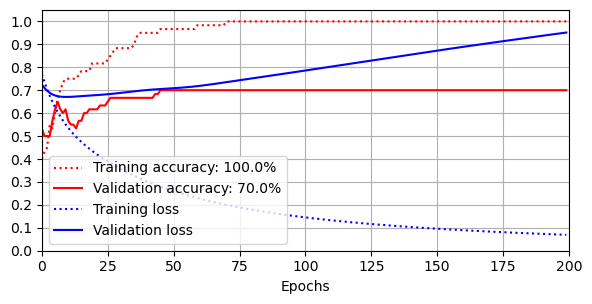

Weights:


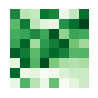

Training Dataset:


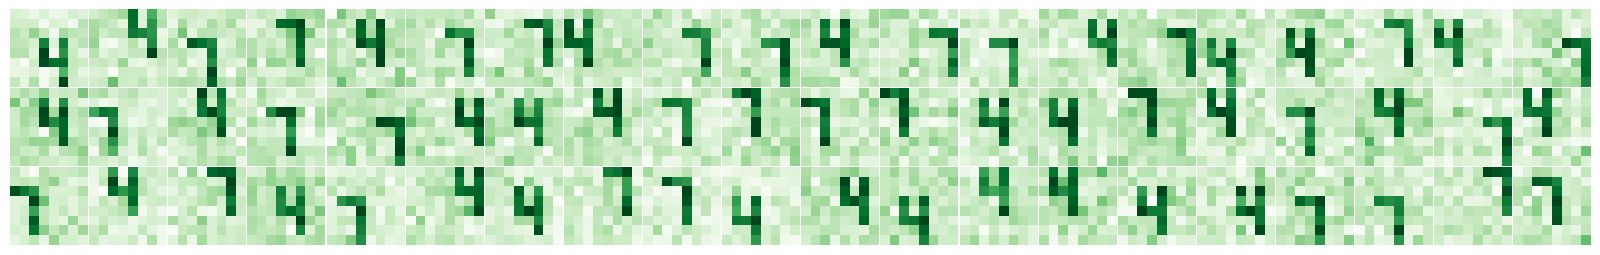

Validation Dataset (misclassified images, if any, are shown in red):


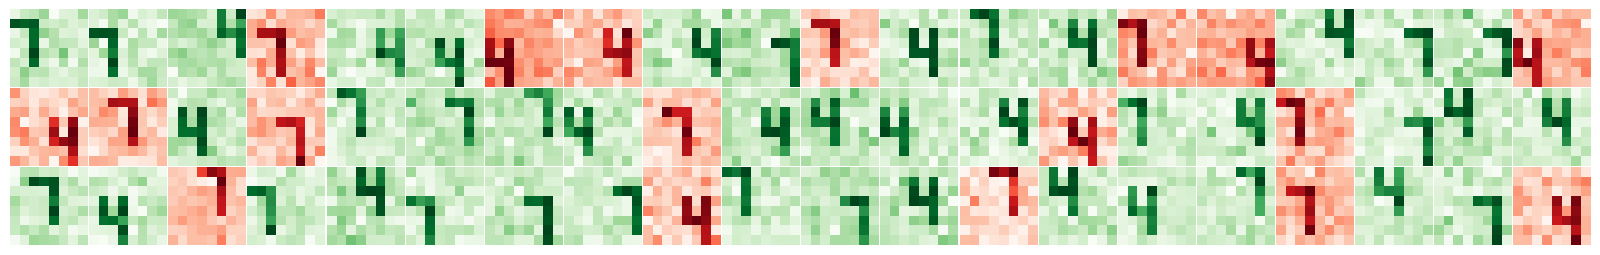

Training accuracy   = 100.0%    Confusion matrix = [[30, 0], [0, 30]]
Validation accuracy =  70.0%    Confusion matrix = [[20, 10], [8, 22]]


In [16]:
#======== Build single-layer perceptron
# inputs = keras.Input((imax,jmax))                                # Xij
# outputs = keras.layers.Dense(1, activation='sigmoid') (inputs)   # Y
# model = keras.Model (inputs=[inputs], outputs=[outputs], name='SLP')
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(imax,jmax)),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid')
])
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model.compile (optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary (line_length=100,print_fn=lambda x: (print(x) if len(x.strip())>0 else None))
#======== Train
history = model.fit(xnijT, ynT, validation_data=(xnijV, ynV), batch_size=nmax, epochs=200, verbose=0, callbacks=[TqdmCallback(verbose=0,ncols=150)])   #100
lossT = history.history['loss']
accuT = history.history['accuracy']
lossV = history.history['val_loss']
accuV = history.history['val_accuracy']
epochs = range(len(lossT))
fig,ax = plt.subplots (1,1, figsize=(6,3)); fig.tight_layout()
ax.plot (epochs, accuT, 'r:', label=f'Training accuracy: {accuT[-1]*100:.1f}%')
ax.plot (epochs, accuV, 'r-', label=f'Validation accuracy: {accuV[-1]*100:.1f}%')
ax.plot (epochs, lossT, 'b:', label='Training loss')
ax.plot (epochs, lossV, 'b-', label='Validation loss')
ax.set_xlabel('Epochs'); ax.set_xlim (0, len(lossT))
ax.set_yticks (np.arange(0,1.01,.1)); ax.set_ylim([0,1.05]); ax.legend(); ax.grid (); plt.show()
#======== Predict
YnT = model(xnijT).numpy().round().astype(int).flatten()
YnV = model(xnijV).numpy().round().astype(int).flatten()
#================ DISPLAY WEIGHTS
wij = model.get_layer(index=1).weights[0].numpy().reshape ((imax,jmax))
print ('Weights:')
gallery ([wij], cmap='Greens'); plt.show()
#================ DISPLAY IMAGES AND CLASSIFICATIONS
print ('Training Dataset:')
gallery (xnijT, cmap=np.where(YnT==ynT,'Greens','Reds')); plt.show()
print ('Validation Dataset (misclassified images, if any, are shown in red):')
gallery (xnijV, cmap=np.where(YnV==ynV,'Greens','Reds')); plt.show()
#================ PRINT METRICS
CnnT = tf.math.confusion_matrix(ynT, YnT).numpy()
CnnV = tf.math.confusion_matrix(ynV, YnV).numpy()
print(f'Training accuracy   = {accuT[-1]*100:5.1f}%    Confusion matrix = {CnnT.tolist()}')
print(f'Validation accuracy = {accuV[-1]*100:5.1f}%    Confusion matrix = {CnnV.tolist()}')

### Do binary classification using CNN

In [30]:
#======== Build CNN
model = keras.Sequential([
  keras.layers.InputLayer ((imax,jmax)),
  keras.layers.BatchNormalization (),
  
  keras.layers.Reshape    (name='r1', target_shape=(imax,jmax,1)),   # NHWC
  keras.layers.Conv2D     (name='c1', filters=1, kernel_size=(5,3), padding='valid', activation='ReLU', kernel_initializer='he_normal'),
  keras.layers.MaxPool2D  (name='p1'),
  keras.layers.Flatten    (name='f1'),
  keras.layers.Dense      (name='d1', units=1, activation='sigmoid')
])
optimizer = keras.optimizers.Adam(learning_rate=0.02)
model.compile (optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary (line_length=100,print_fn=lambda x: (print(x) if len(x.strip())>0 else None))
#======== Train
history = model.fit(xnijT, ynT, validation_data=(xnijV, ynV), batch_size=nmax, epochs=500, verbose=0, callbacks=[TqdmCallback(verbose=0,ncols=150)])   #100

Model: "sequential_12"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 batch_normalization (BatchNormalization)    (None, 8, 8)                            32             
 r1 (Reshape)                                (None, 8, 8, 1)                         0              
 c1 (Conv2D)                                 (None, 4, 6, 1)                         16             
 p1 (MaxPooling2D)                           (None, 2, 3, 1)                         0              
 f1 (Flatten)                                (None, 6)                               0              
 d1 (Dense)                                  (None, 1)                               7              
Total params: 55
Trainable params: 39
Non-trainable params: 16
____________________________________________________________________________________________________


0epoch [00:00, ?epoch/s]

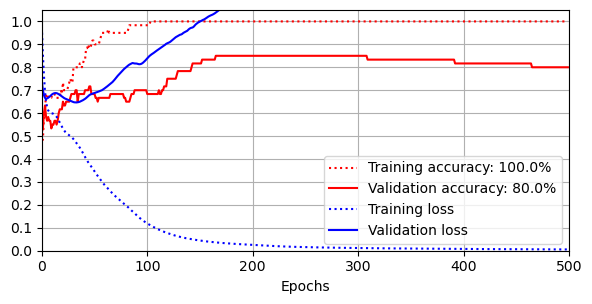

In [31]:
lossT = history.history['loss']
accuT = history.history['accuracy']
lossV = history.history['val_loss']
accuV = history.history['val_accuracy']
epochs = range(len(lossT))
fig,ax = plt.subplots (1,1, figsize=(6,3)); fig.tight_layout()
ax.plot (epochs, accuT, 'r:', label=f'Training accuracy: {accuT[-1]*100:.1f}%')
ax.plot (epochs, accuV, 'r-', label=f'Validation accuracy: {accuV[-1]*100:.1f}%')
ax.plot (epochs, lossT, 'b:', label='Training loss')
ax.plot (epochs, lossV, 'b-', label='Validation loss')
ax.set_xlabel('Epochs'); ax.set_xlim (0, len(lossT))
ax.set_yticks (np.arange(0,1.01,.1)); ax.set_ylim([0,1.05]); ax.legend(); ax.grid (); plt.show()
#======== Predict
YnT = model(xnijT).numpy().round().astype(int).flatten()
YnV = model(xnijV).numpy().round().astype(int).flatten()
#================ DISPLAY WEIGHTS
wijcc = model.get_layer(name='c1').weights[0].numpy()

Weights:


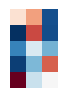

Training Dataset:


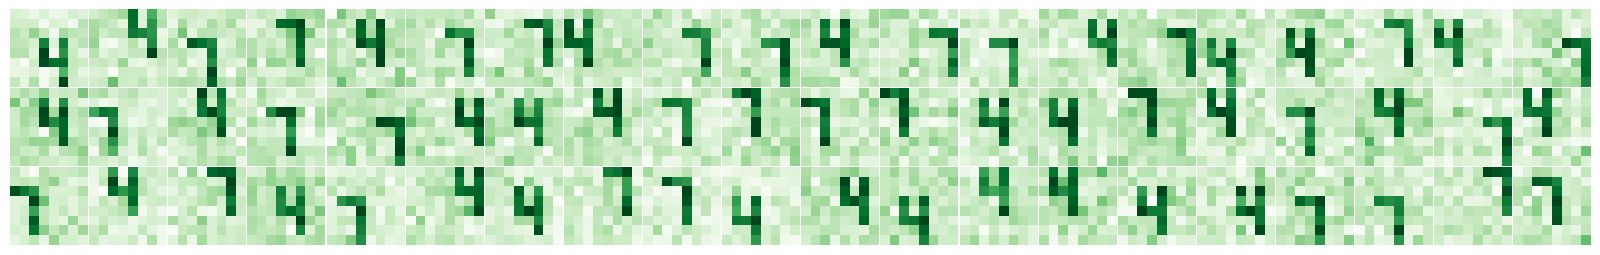

Validation Dataset (misclassified images, if any, are shown in red):


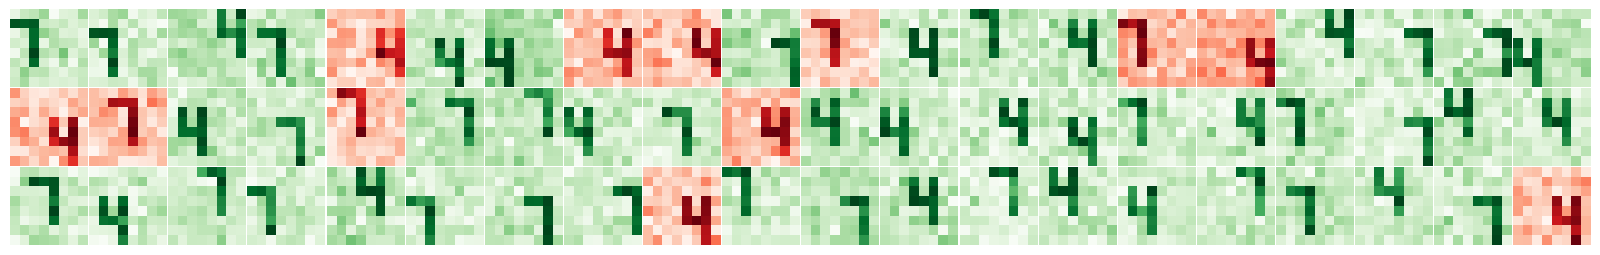

Training accuracy   = 100.0%    Confusion matrix = [[30, 0], [0, 30]]
Validation accuracy =  80.0%    Confusion matrix = [[26, 4], [8, 22]]


In [32]:
wijc = wijcc.reshape((wijcc.shape[0],wijcc.shape[1],-1))
wcij = wijc.transpose((2,0,1))
#wijc.shape, wcij.shape
print ('Weights:')
gallery (wcij, cmap='RdBu'); plt.show()
#================ DISPLAY IMAGES AND CLASSIFICATIONS
print ('Training Dataset:')
gallery (xnijT, cmap=np.where(YnT==ynT,'Greens','Reds')); plt.show()
print ('Validation Dataset (misclassified images, if any, are shown in red):')
gallery (xnijV, cmap=np.where(YnV==ynV,'Greens','Reds')); plt.show()
#================ PRINT METRICS
CnnT = tf.math.confusion_matrix(ynT, YnT).numpy()
CnnV = tf.math.confusion_matrix(ynV, YnV).numpy()
print(f'Training accuracy   = {accuT[-1]*100:5.1f}%    Confusion matrix = {CnnT.tolist()}')
print(f'Validation accuracy = {accuV[-1]*100:5.1f}%    Confusion matrix = {CnnV.tolist()}')

### Debugging tips

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])